In [2]:
import pandas as pd
import plotnine as pn
import numpy as np

CONVERT_100_GW_to_GW = 100
RENEWABLES = ["open_field_pv", "roof_mounted_pv", "wind", "awe"]


def aggregate_locs(df):
    _df = df.copy()
    _df["locs"] = _df["locs"].replace({"_\\d+$": ""}, regex=True)
    _df = _df.groupby(["locs", "techs"]).sum().reset_index().set_index("locs")
    return _df


def filter_techs(df, filter_techs):
    if not isinstance(filter_techs, list):
        filter_techs = [filter_techs]
    return df.loc[df.techs.apply(lambda x: any([f in x for f in filter_techs]), 1),:]


def drop_nan_inf(series):
    return series.loc[~series.isna() & (~series.isin([np.inf, -np.inf]))]

In [3]:
# energy_cap = aggregate_locs(pd.read_csv("../build/postprocessed_results/energy_cap.csv")).reset_index()
# energy_cap_max = aggregate_locs(pd.read_csv("../build/postprocessed_results/energy_cap_max.csv")).reset_index()
# energy_cap.energy_cap = energy_cap.energy_cap * CONVERT_10000_MW_to_GW
# energy_cap_max.energy_cap_max = energy_cap_max.energy_cap_max * CONVERT_10000_MW_to_GW
# df = energy_cap.merge(energy_cap_max, on=["locs", "techs"])

# df.loc[df["energy_cap_max"] == np.inf, "share"] = np.nan
df = pd.read_csv("../build/postprocessed_results/energy_cap_res_6h.csv")
df.loc[:, ["energy_cap", "energy_cap_max"]] *= CONVERT_100_GW_to_GW
df["share"] = df.energy_cap / df.energy_cap_max
df.sort_values("share")

,locs,techs,energy_cap,energy_cap_max,share
3843,FRA_8,syn_diesel_distribution_import,279.389235,inf,0.0
4510,GRC_2,chp_methane_extraction_heat_storage_big,0.000559,inf,0.0
4509,GRC_2,chp_methane_extraction,0.000158,inf,0.0
4508,GRC_2,chp_hydrogen_tech_heat_to_demand,0.000066,inf,0.0
4507,GRC_2,chp_hydrogen_heat_storage_big,0.001089,inf,0.0
...,...,...,...,...,...
7274,SVK_1,wind_offshore,0.000000,0.0,NaN
7413,SWE_1,pumped_hydro,0.000000,0.0,NaN
7490,SWE_2,pumped_hydro,0.000000,0.0,NaN
7637,SWE_4,hydro_run_of_river,0.000000,0.0,NaN


In [4]:
df_re = filter_techs(df, RENEWABLES)
df_re = df_re.loc[~df_re.energy_cap_max.isna() & (~df_re.energy_cap_max.isin([np.inf, -np.inf])), :]
# df_re = df_re.loc[~df_re.share.isna() & (~df_re.share.isin([np.inf, -np.inf])), :]
# df_re = aggregate_locs(df_re).reset_index()
df_re

,locs,techs,energy_cap,energy_cap_max,share
60,ALB_1,roof_mounted_pv,0.000180,13.766374,1.305473e-05
74,ALB_1,wind_offshore,0.000072,29.490618,2.429302e-06
76,ALB_1,wind_onshore_monopoly,0.000152,68.797663,2.214994e-06
139,AUT_1,roof_mounted_pv,0.000180,18.244186,9.884061e-06
153,AUT_1,wind_offshore,0.000000,0.000000,NaN
...,...,...,...,...,...
7586,SWE_3,wind_offshore,0.000165,582.357941,2.826476e-07
7588,SWE_3,wind_onshore_monopoly,0.501100,805.649090,6.219832e-04
7650,SWE_4,roof_mounted_pv,0.000191,15.741906,1.213737e-05
7664,SWE_4,wind_offshore,0.000092,74.259127,1.236853e-06


       locs                  techs  energy_cap  energy_cap_max         share  \
60    ALB_1        roof_mounted_pv    0.000180       13.766374  1.305473e-05   
74    ALB_1          wind_offshore    0.000072       29.490618  2.429302e-06   
76    ALB_1  wind_onshore_monopoly    0.000152       68.797663  2.214994e-06   
139   AUT_1        roof_mounted_pv    0.000180       18.244186  9.884061e-06   
153   AUT_1          wind_offshore    0.000000        0.000000           NaN   
...     ...                    ...         ...             ...           ...   
7586  SWE_3          wind_offshore    0.000165      582.357941  2.826476e-07   
7588  SWE_3  wind_onshore_monopoly    0.501100      805.649090  6.219832e-04   
7650  SWE_4        roof_mounted_pv    0.000191       15.741906  1.213737e-05   
7664  SWE_4          wind_offshore    0.000092       74.259127  1.236853e-06   
7666  SWE_4  wind_onshore_monopoly   38.018691      132.932284  2.860004e-01   

      order  
60    ALB_1  
74    ALB_1

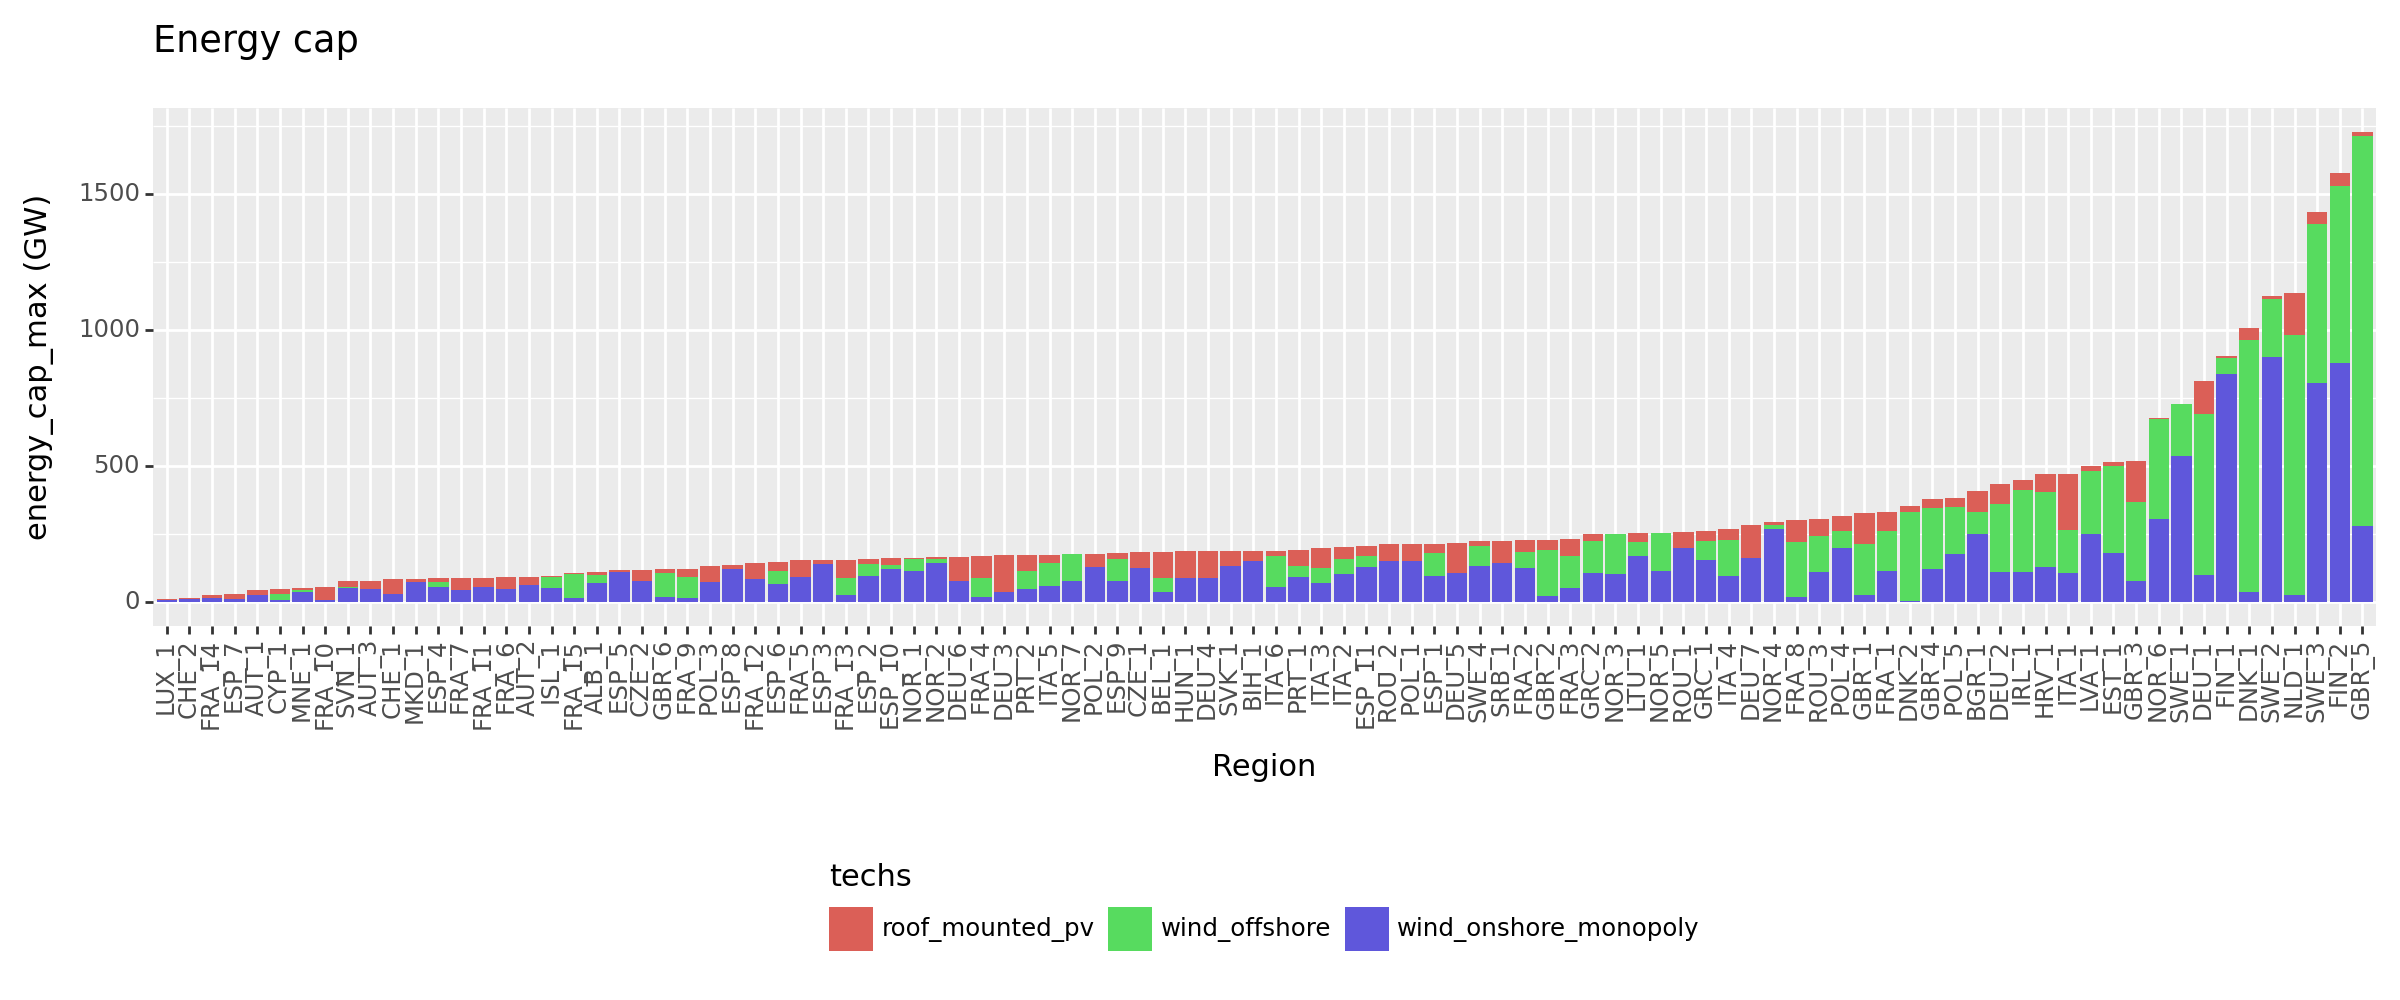

<Figure Size: (1200 x 500)>

In [14]:
var_name = "energy_cap_max" # "energy_cap" "energy_cap_max" "share"
var_unit = "GW"
data = df_re.copy()

sort = True
if sort:
    order = data.set_index(["locs", "techs"]).loc[:, var_name].groupby("locs").sum().sort_values(ascending=True).index
    data = data.assign(order=pd.Categorical(data["locs"], categories=order, ordered=True))

normalization = False
if normalization:
    data.loc[:, var_name] = data.loc[:, var_name] / data.loc[:, var_name].sum()
print(data)
(
    pn.ggplot(data)
    + pn.geom_col(pn.aes(x="order", y=var_name, fill="techs"))
    + pn.labs(x="Region", y=f"{var_name} ({var_unit})", title="Energy cap")
    + pn.scale_color_discrete(guide=False)
    + pn.theme(figure_size=(12, 5))
    + pn.theme(axis_text_x=pn.element_text(angle=90), legend_position="bottom")
)

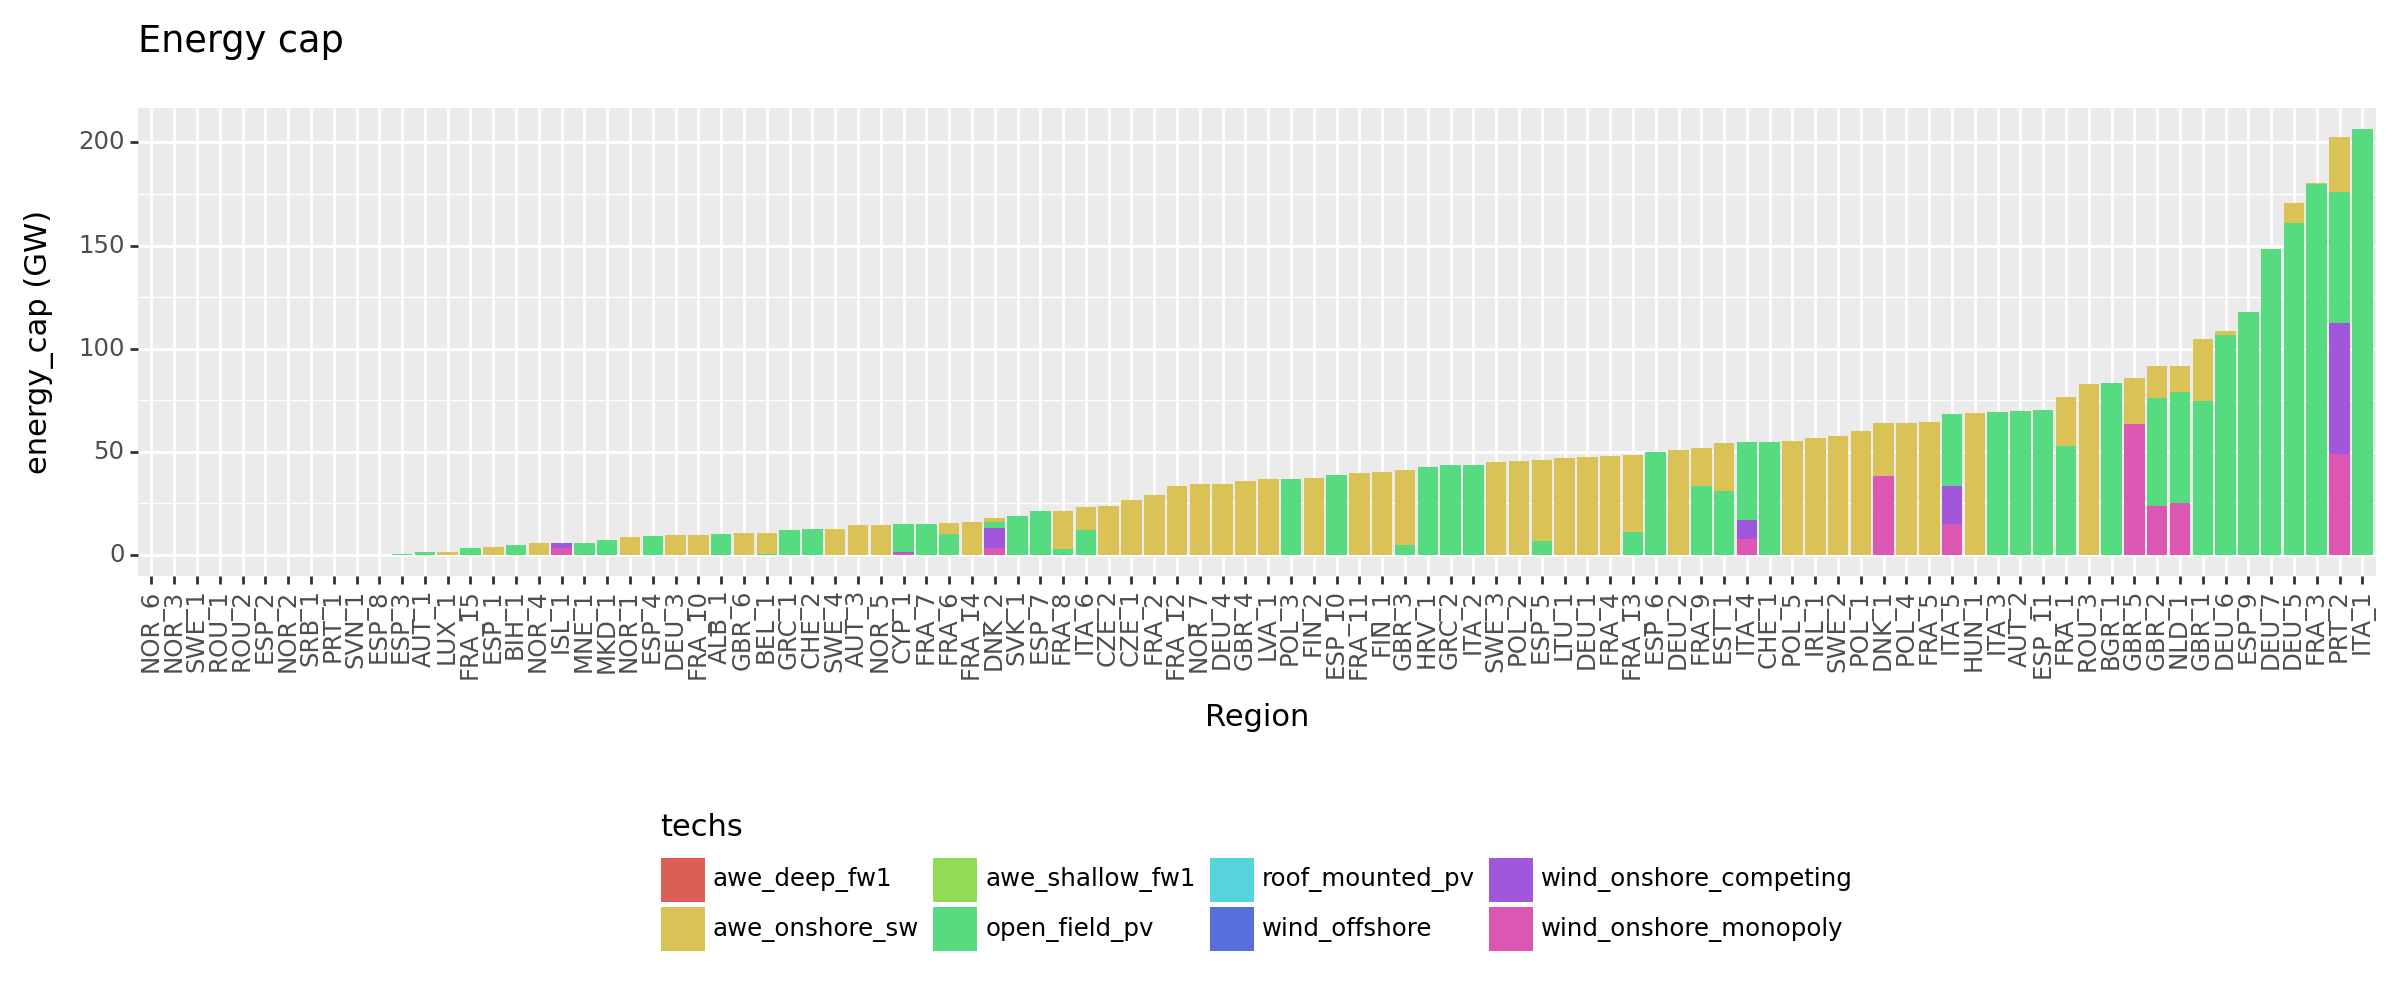

<Figure Size: (1200 x 500)>

In [25]:
data = df_re
var_name = "energy_cap" # "energy_cap" "energy_cap_max" "share"
var_unit = "GW"
sort = True
if sort:
    order = data.set_index(["locs", "techs"]).loc[:, var_name].groupby("locs").sum().sort_values(ascending=True).index
    data = data.assign(order=pd.Categorical(data["locs"], categories=order, ordered=True))
(
    pn.ggplot(data)
    + pn.geom_col(pn.aes(x="order", y=var_name, fill="techs"))
    + pn.labs(x="Region", y=f"{var_name} ({var_unit})", title="Energy cap")
    + pn.scale_color_discrete(guide=False)
    + pn.theme(figure_size=(12, 5))
    + pn.theme(axis_text_x=pn.element_text(angle=90), legend_position="bottom")
)

In [206]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [218]:
eez = "../build/shapes/eez.geojson"
eurospores = "../data/europe-98-zones.geojson/europe-98-zones.geojson"

eez = gpd.read_file(eez).to_crs("EPSG:3879")
eurospores = gpd.read_file(eurospores).to_crs("EPSG:3879")

energy_cap = pd.read_csv("../build/postprocessed_results/energy_cap.csv")
energy_cap_max = pd.read_csv("../build/postprocessed_results/energy_cap_max.csv")
energy_cap.energy_cap = energy_cap.energy_cap * CONVERT_10000_MW_to_GW
energy_cap_max.energy_cap_max = energy_cap_max.energy_cap_max * CONVERT_10000_MW_to_GW
df = energy_cap.merge(energy_cap_max, on=["locs", "techs"])
df

,locs,techs,energy_cap,energy_cap_max
0,ALB_1,ac_ohl_mountain_transmission:GRC_1,0.800014,32.000000
1,ALB_1,ac_ohl_mountain_transmission:MKD_1,0.700012,28.000000
2,ALB_1,ac_ohl_transmission:MNE_1,1.924682,36.000000
3,ALB_1,ac_ohl_transmission:SRB_1,29.499737,36.000000
4,ALB_1,awe_deep_fw1,0.000066,inf
...,...,...,...,...
7714,SWE_4,syn_methanol_distribution_import,197.632457,inf
7715,SWE_4,waste_supply,0.429736,inf
7716,SWE_4,wind_offshore,0.000077,74.259127
7717,SWE_4,wind_onshore_competing,25.919374,inf


In [219]:
eurospores

,id,country_code,name,type,proper,geometry
0,ALB_1,ALB,Albania,country,True,"MULTIPOLYGON (((25070857.636 4416551.226, 2507..."
1,AUT_1,AUT,custom_region,custom_region,True,"MULTIPOLYGON (((24677637.511 5230477.533, 2467..."
2,AUT_2,AUT,custom_region,custom_region,True,"MULTIPOLYGON (((24677394.646 5231419.776, 2467..."
3,AUT_3,AUT,custom_region,custom_region,True,"MULTIPOLYGON (((24813936.095 5229681.679, 2481..."
4,BEL_1,BEL,Belgium,country,True,"MULTIPOLYGON (((24172192.698 5768924.444, 2417..."
...,...,...,...,...,...,...
93,SVN_1,SVN,Slovenia,country,True,"MULTIPOLYGON (((24613715.405 5140147.535, 2461..."
94,SWE_1,SWE,custom_region,custom_region,True,"MULTIPOLYGON (((25340690.966 7226341.322, 2534..."
95,SWE_2,SWE,custom_region,custom_region,True,"MULTIPOLYGON (((25081231.928 6755113.155, 2508..."
96,SWE_3,SWE,custom_region,custom_region,True,"MULTIPOLYGON (((25088385.758 6375746.028, 2508..."


In [243]:
df_tech = filter_techs(df, ["onshore"])
df_tech


,locs,techs,energy_cap,energy_cap_max
77,ALB_1,wind_onshore_competing,0.000206,inf
78,ALB_1,wind_onshore_monopoly,0.000140,68.797663
156,AUT_1,wind_onshore_competing,0.000125,inf
157,AUT_1,wind_onshore_monopoly,0.000135,26.883848
234,AUT_2,wind_onshore_competing,0.000264,inf
...,...,...,...,...
7559,SWE_2,wind_onshore_monopoly,0.000397,901.109442
7639,SWE_3,wind_onshore_competing,0.001301,inf
7640,SWE_3,wind_onshore_monopoly,0.001040,805.649090
7717,SWE_4,wind_onshore_competing,25.919374,inf


In [241]:
shapes_with_values = df_tech.merge(eurospores, left_on="locs", right_on="id", how="left")
shapes_with_values = gpd.GeoDataFrame(shapes_with_values)
shapes_with_values

,locs,techs,energy_cap,energy_cap_max,id,country_code,name,type,proper,geometry
0,ALB_1,awe_shallow_fw1,0.000067,inf,ALB_1,ALB,Albania,country,True,"MULTIPOLYGON (((25070857.636 4416551.226, 2507..."
1,BEL_1,awe_shallow_fw1,0.000174,inf,BEL_1,BEL,Belgium,country,True,"MULTIPOLYGON (((24172192.698 5768924.444, 2417..."
2,BGR_1,awe_shallow_fw1,0.000104,inf,BGR_1,BGR,Bulgaria,country,True,"MULTIPOLYGON (((25629526.174 4644627.354, 2563..."
3,BIH_1,awe_shallow_fw1,0.000042,inf,BIH_1,BIH,Bosnia and Herzegovina,country,True,"MULTIPOLYGON (((24966923.243 4760993.073, 2496..."
4,CYP_1,awe_shallow_fw1,0.000077,inf,CYP_1,CYP,Cyprus,country,True,"MULTIPOLYGON (((26253497.534 3872941.323, 2625..."
5,DEU_1,awe_shallow_fw1,0.000540,inf,DEU_1,DEU,custom_region,custom_region,True,"MULTIPOLYGON (((24426955.125 5806066.269, 2442..."
6,DNK_1,awe_shallow_fw1,0.000188,inf,DNK_1,DNK,custom_region,custom_region,True,"MULTIPOLYGON (((24577636.391 6175829.550, 2457..."
7,ESP_1,awe_shallow_fw1,0.000064,inf,ESP_1,ESP,custom_region,custom_region,True,"MULTIPOLYGON (((22692333.236 5267767.589, 2269..."
8,EST_1,awe_shallow_fw1,0.000109,inf,EST_1,EST,Estonia,country,True,"MULTIPOLYGON (((25355212.573 6450144.169, 2535..."
9,FIN_1,awe_shallow_fw1,0.000114,inf,FIN_1,FIN,custom_region,custom_region,True,"MULTIPOLYGON (((25436083.576 7121437.180, 2543..."


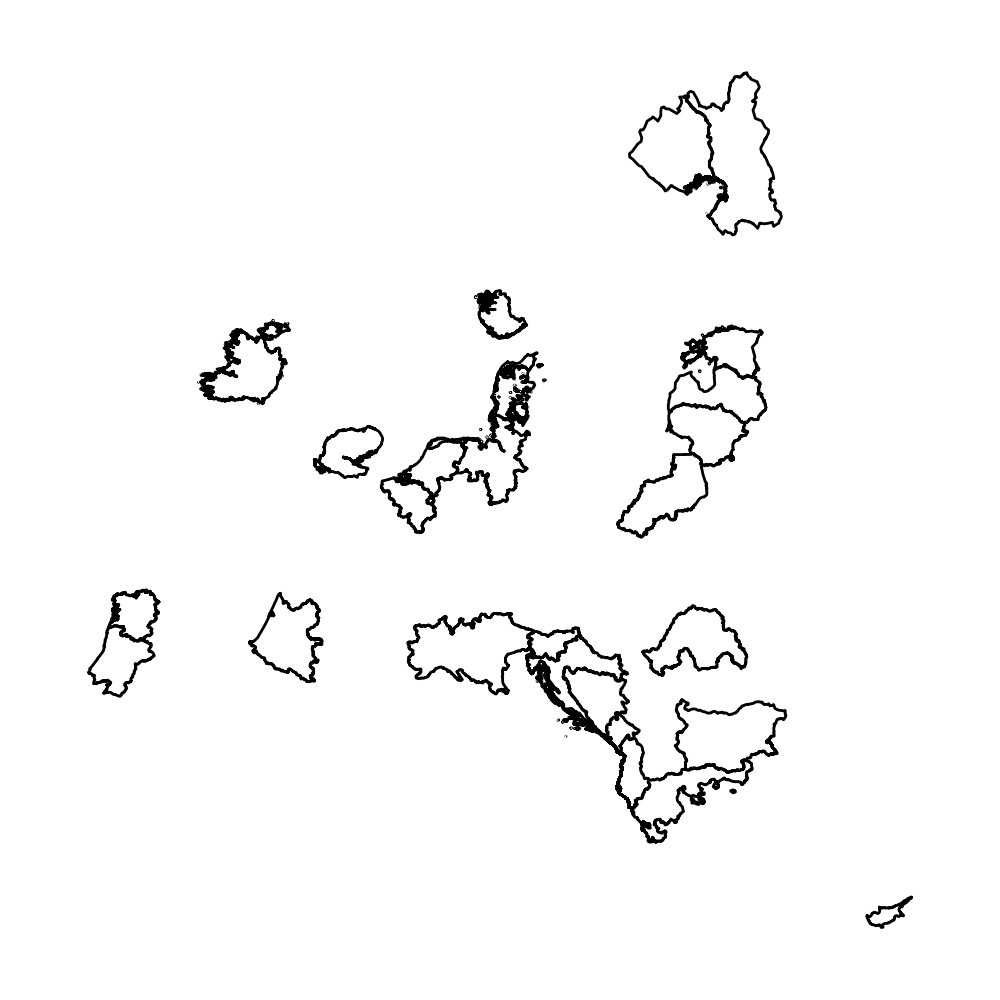

In [240]:
# offshore capacities only visible for national onshore regions
# onshore for 98 eurospores
fig, ax = plt.subplots(figsize=(5, 5))
shapes_with_values.geometry.boundary.plot(ax=ax, color=None, edgecolor='k', linewidth=1)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [8]:
national_energy_cap = pd.read_csv("national_energy_cap.csv")

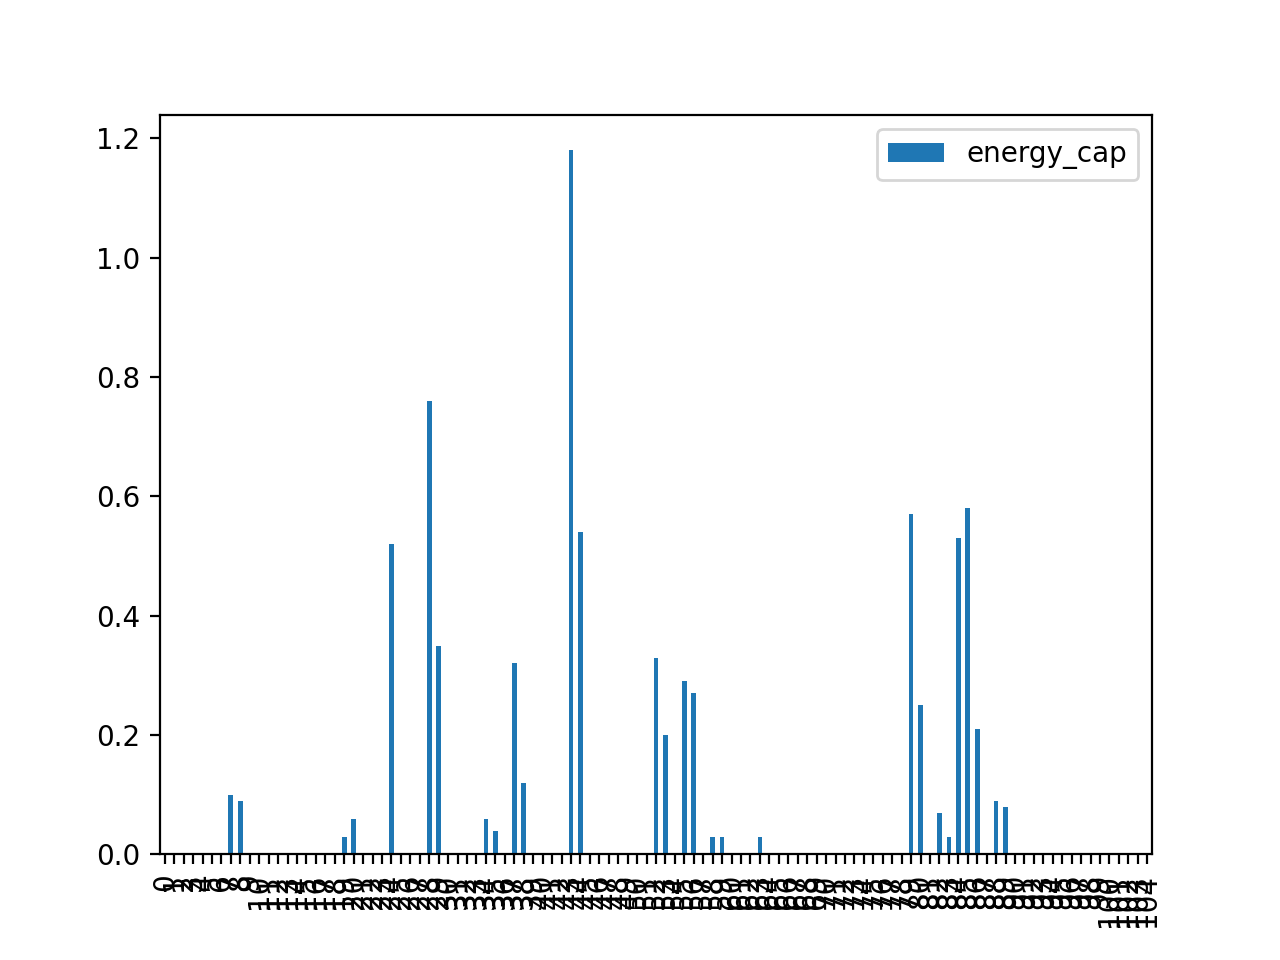

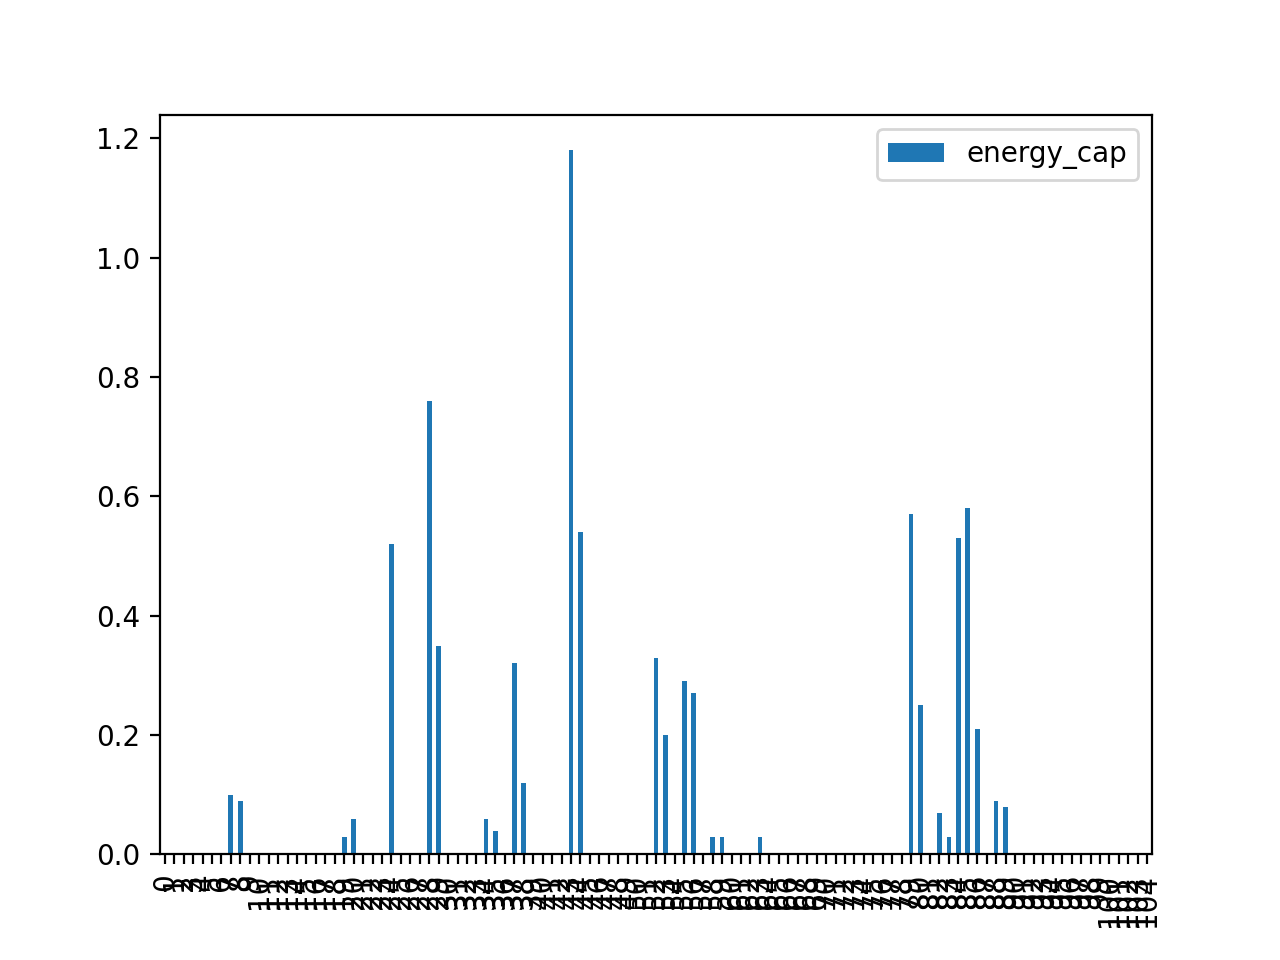

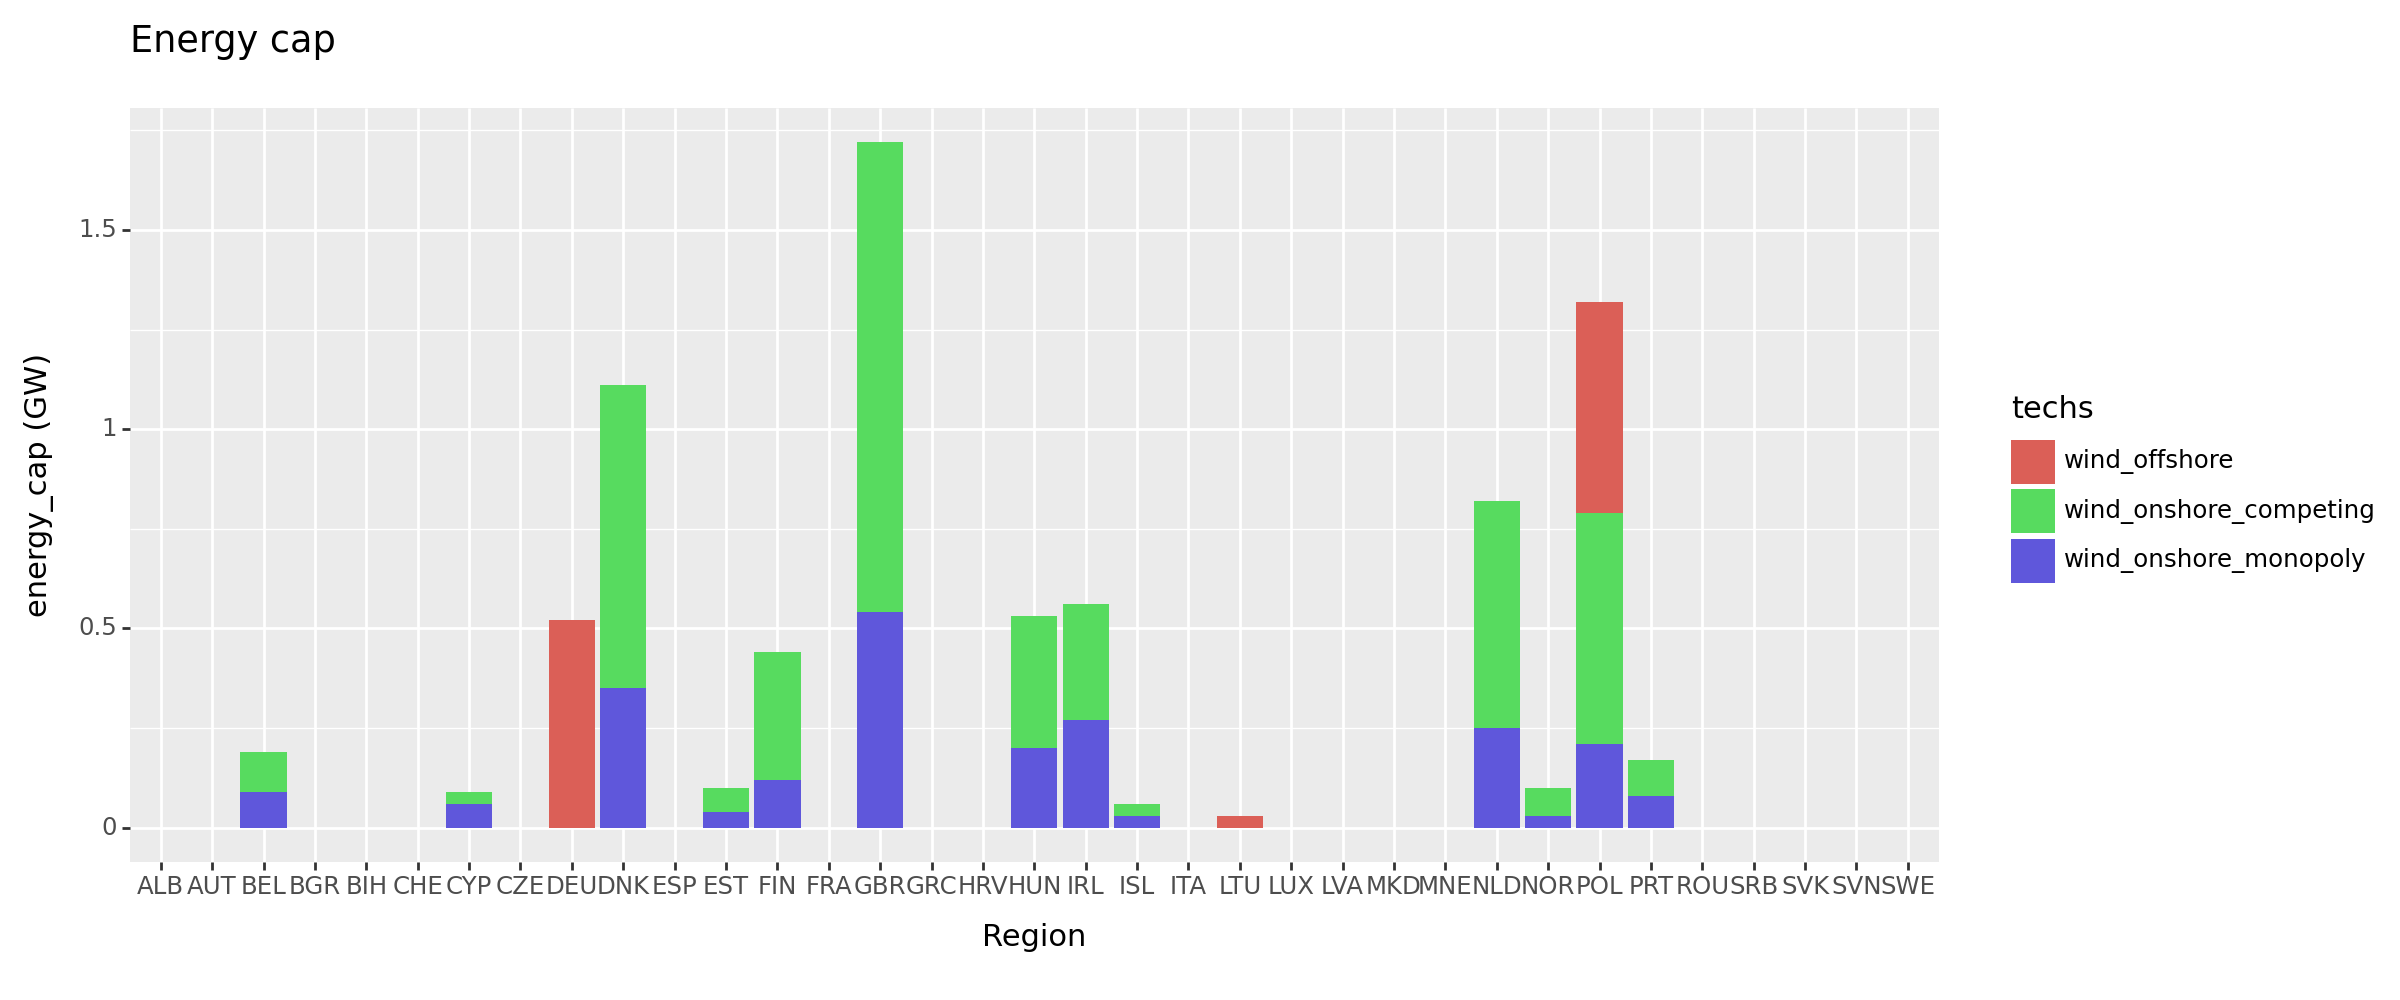

<Figure Size: (1200 x 500)>

In [12]:
data = national_energy_cap
var_name = "energy_cap" # "energy_cap" "energy_cap_max" "share"
(
    pn.ggplot(data)
    + pn.geom_col(pn.aes(x="locs", y=var_name, fill="techs"))
    + pn.labs(x="Region", y=f"{var_name} ({var_unit})", title="Energy cap")
    + pn.scale_color_discrete(guide=False)
    + pn.theme(figure_size=(12, 5))
)